In [1]:
import torch
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [2]:
!pip install pyro-ppl

In [4]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn

from pyro.infer import MCMC, NUTS, Predictive


pyro.set_rng_seed(42)

In [86]:
# Real Observations

t_obs = torch.linspace(0., 8., 1500).unsqueeze(-1)          # 1500 × 1
u_true = 0.5*t_obs**2 + t_obs
noise = 0.1
u_obs = u_true + noise * torch.randn_like(u_true)     # 1500 X 1
# u_obs = u_obs.squeeze()       # 1500,


# Collocation Points
t_pde = torch.linspace(0., 8., 1000).unsqueeze(-1).requires_grad_(True)

# initial condition point
t_ic = torch.tensor([[0.0]])

In [87]:
class PhyBNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=20):
        super().__init__()

        self.activation = nn.Tanh()  
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, hid_dim)
        self.layer3 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., 1.).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., 10.).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., 1.).expand([hid_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., 10.).expand([hid_dim]).to_event(1))
        self.layer3.weight = PyroSample(dist.Normal(0., 1.).expand([out_dim, hid_dim]).to_event(2))
        self.layer3.bias = PyroSample(dist.Normal(0., 10.).expand([out_dim]).to_event(1))

    def forward(self,t):
        h_1 = self.activation(self.layer1(t))
        h_2 = self.activation(self.layer2(h_1))
        return self.layer3(h_2).squeeze(-1)
    


In [89]:
def model_pinn(t_pde, t_ic):
    
    net = PhyBNN()

    # t_pde = t_pde.detach().requires_grad_(True)
    t_pde = t_pde.requires_grad_()
    t_ic  = t_ic.requires_grad_()

    t_all = torch.cat([t_pde, t_ic], dim=0).requires_grad_()
    
    u_all = net(t_all)
    u_pde, u_ic = u_all[: len(t_pde)], u_all[len(t_pde) :]

    # print(u_pde)
    
    n_pde = t_pde.shape[0]
    
    #PDE
    # u_pred_pde = net(t_pde)
    du_dt_all = torch.autograd.grad(u_all,t_all,grad_outputs=torch.ones_like(u_all), create_graph=True)[0]
    du_dt = du_dt_all[:n_pde]
    res_pde = du_dt - t_all[:n_pde]
    #IC
    # u_pred_ic = net(t_ic)
    res_ic = u_ic

    # Likelihoods
    with pyro.plate('pde_plate',len(t_pde)):
        pyro.sample('pde_obs', dist.Normal(0.,1e-1), obs = res_pde.squeeze())
    with pyro.plate('ic_plate',len(t_ic)):
        pyro.sample('ic_obs', dist.Normal(0.,1e-1), obs = res_ic.squeeze())


    



In [90]:
pyro.clear_param_store()
nuts_kernel = NUTS(model_pinn, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=400, warmup_steps=100, num_chains=1)
mcmc.run(t_pde,t_ic)





Sample: 100%|██████████| 500/500 [16:24,  1.97s/it, step size=8.81e-04, acc. prob=0.674]


In [91]:
posterior_samples = mcmc.get_samples()

for name, vals in posterior_samples.items():
    print(name, vals.shape)

layer1.bias torch.Size([400, 20])
layer1.weight torch.Size([400, 20, 1])
layer2.bias torch.Size([400, 20])
layer2.weight torch.Size([400, 20, 20])
layer3.bias torch.Size([400, 1])
layer3.weight torch.Size([400, 1, 20])


In [92]:
def model_pinn_return(t_pde,t_ic):
    net = PhyBNN()
    return net(t_pde)

In [107]:
t_test = torch.linspace(0., 8., steps=1000).unsqueeze(-1)


predictive = Predictive(model_pinn_return,posterior_samples=posterior_samples,return_sites=["_RETURN"])

output = predictive(t_test, t_ic)
print(output.keys())

u_pred_samples = output["_RETURN"]   # shape [S, N]
print(u_pred_samples.shape)

u_pred_samples = output["_RETURN"]    # shape [num_samples, len(t_test)]

mean_pred = u_pred_samples.mean(0)
std_pred = u_pred_samples.std(dim=0)
lower_90  = u_pred_samples.quantile(0.10, dim=0)
upper_90  = u_pred_samples.quantile(0.90, dim=0)

print((upper_90 - lower_90).mean().item())

dict_keys(['_RETURN'])
torch.Size([400, 1000])
0.27535831928253174


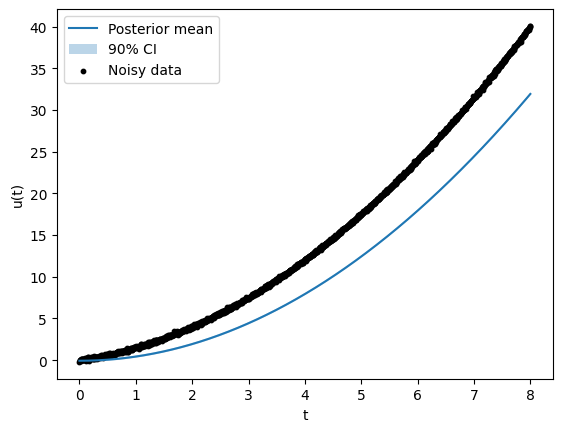

In [108]:
x = t_test.squeeze().numpy()
plt.plot(x, mean_pred, label="Posterior mean")
plt.fill_between(x, lower_90, upper_90, alpha=0.3, label="90% CI")
# plt.fill_between(x, mean_pred - 2*std_pred, mean_pred + 2*std_pred, alpha=0.3, label="±2 std")
plt.scatter(t_obs.numpy(), u_obs.numpy(), c="k", s=10, label="Noisy data")
plt.legend()
plt.xlabel("t"); plt.ylabel("u(t)")
plt.show()

In [109]:
# Stage 2: Condition on data, starting from the physics‐informed posterior


mean_w1 = posterior_samples["layer1.weight"].mean(0)
std_w1  = posterior_samples["layer1.weight"].std(0)

print(mean_w1.shape)

mean_b1 = posterior_samples["layer1.bias"].mean(0)
std_b1 = posterior_samples["layer1.bias"].std(0)

print(mean_b1.shape)





mean_w2 = posterior_samples["layer2.weight"].mean(0)
std_w2  = posterior_samples["layer2.weight"].std(0)

mean_b2 = posterior_samples["layer2.bias"].mean(0)
std_b2 = posterior_samples["layer2.bias"].std(0)


print(mean_w2.shape)
print(mean_b2.shape)



mean_w3 = posterior_samples["layer3.weight"].mean(0)
std_w3  = posterior_samples["layer3.weight"].std(0)

mean_b3 = posterior_samples["layer3.bias"].mean(0)
std_b3 = posterior_samples["layer3.bias"].std(0)

print(mean_w3.shape)
print(mean_b3.shape)


torch.Size([20, 1])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([1, 20])
torch.Size([1])


In [110]:
class PhyDataBNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=20):
        super().__init__()

        self.activation = nn.Tanh()  
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, hid_dim)
        self.layer3 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(mean_w1, std_w1).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(mean_b1, std_b1).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(mean_w2, std_w2).expand([hid_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(mean_b2, std_b2).expand([hid_dim]).to_event(1))
        self.layer3.weight = PyroSample(dist.Normal(mean_w3, std_w3).expand([out_dim, hid_dim]).to_event(2))
        self.layer3.bias = PyroSample(dist.Normal(mean_b3, std_b3).expand([out_dim]).to_event(1))

    def forward(self,t):
        h_1 = self.activation(self.layer1(t))
        h_2 = self.activation(self.layer2(h_1))
        return self.layer3(h_2).squeeze(-1)
    


In [111]:
def model_pinn_data(t_pde, t_ic,t_obs):
    
    net_2 = PhyDataBNN()

    # t_pde = t_pde.detach().requires_grad_(True)
    t_pde = t_pde.requires_grad_()
    t_ic  = t_ic.requires_grad_()
    t_obs = t_obs.requires_grad_()

    t_all_2 = torch.cat([t_pde, t_ic,t_obs], dim=0).requires_grad_()
    
    u_all_2 = net_2(t_all_2)
    u_pde, u_ic,u_pred_data = u_all_2[: len(t_pde)], u_all_2[len(t_pde) : len(t_pde) + len(t_ic)], u_all_2[len(t_pde) + len(t_ic):]
    n_pde = t_pde.shape[0]
    
    #PDE
    # u_pred_pde = net(t_pde)
    du_dt_all = torch.autograd.grad(u_all_2,t_all_2,grad_outputs=torch.ones_like(u_all_2), create_graph=True)[0]
    du_dt = du_dt_all[:n_pde]
    res_pde = du_dt - t_all_2[:n_pde]
    #IC
    # u_pred_ic = net(t_ic)
    res_ic = u_ic

    # u_data_pred = net_2(t_obs)

    # Likelihoods
    with pyro.plate('pde_plate',len(t_pde)):
        pyro.sample('pde_obs', dist.Normal(0.,1e-1), obs = res_pde.squeeze())
    with pyro.plate('ic_plate',len(t_ic)):
        pyro.sample('ic_obs', dist.Normal(0.,1e-1), obs = res_ic.squeeze())
    with pyro.plate('data',len(t_obs)):
        pyro.sample('obs', dist.Normal(u_pred_data,1e-1), obs = u_obs)
    



In [112]:
pyro.clear_param_store()
nuts_kernel_2 = NUTS(model_pinn_data, adapt_step_size=True)
mcmc_2 = MCMC(nuts_kernel_2, num_samples=400, warmup_steps=100, num_chains=1)
mcmc_2.run(t_pde,t_ic,t_obs)

Sample: 100%|██████████| 500/500 [00:20, 24.47it/s, step size=1.53e-06, acc. prob=0.508]


In [113]:
posterior_samples_2 = mcmc_2.get_samples()

for name, vals in posterior_samples_2.items():
    print(name, vals.shape)

layer1.bias torch.Size([400, 20])
layer1.weight torch.Size([400, 20, 1])
layer2.bias torch.Size([400, 20])
layer2.weight torch.Size([400, 20, 20])
layer3.bias torch.Size([400, 1])
layer3.weight torch.Size([400, 1, 20])


In [114]:
def model_pinn_data_return(t_pde,t_ic,t_obs):
    net_2 = PhyDataBNN()
    return net_2(t_pde)

In [115]:
t_test = torch.linspace(0., 8., steps=1000).unsqueeze(-1)


predictive_2 = Predictive(model_pinn_data_return,posterior_samples=posterior_samples_2,return_sites=["_RETURN"])

output_2 = predictive_2(t_test, t_ic,t_obs)
print(output_2.keys())

u_pred_samples_2 = output_2["_RETURN"]    # shape [num_samples, len(t_test)]
print(u_pred_samples_2.shape)

mean_pred_2 = u_pred_samples_2.mean(0)
lower_90_2  = u_pred_samples_2.quantile(0.10, dim=0)
upper_90_2  = u_pred_samples_2.quantile(0.90, dim=0)


print((upper_90_2 - lower_90_2).mean().item())

dict_keys(['_RETURN'])
torch.Size([400, 1000])
3.623962356869015e-06


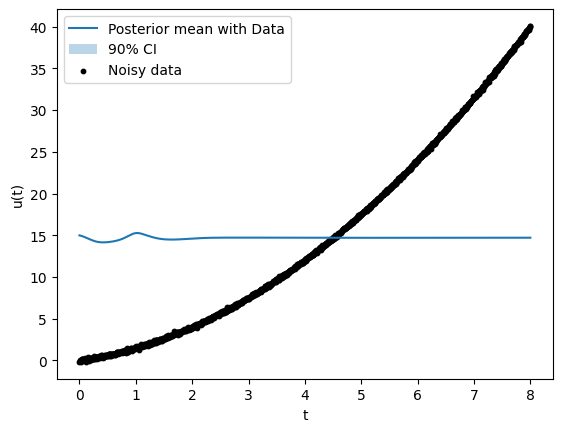

In [ ]:
x = t_test.squeeze().numpy()
plt.plot(x, mean_pred_2, label="Posterior mean with Data")
plt.fill_between(x, lower_90_2, upper_90_2, alpha=0.3, label="90% CI")
plt.scatter(t_obs.numpy(), u_obs.numpy(), c="k", s=10, label="Noisy data")
plt.legend()
plt.xlabel("t"); plt.ylabel("u(t)")
plt.show()